# Imports

In [108]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, classification_report
from bayes_opt import BayesianOptimization
import shap

# Import Data

In [4]:
model_data = pd.read_csv('model_data.csv')

In [5]:
model_data.shape

(641914, 92)

# Split Data

We will split the data into 3 sets.

1. Train: used for training the model
2. Validation: used as an unseen data set to compare model performances
3. Test: used to determine the final expected performance of the model

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(model_data.drop(columns='isFraud')
                                                       , model_data['isFraud']
                                                       , test_size=0.3
                                                       , random_state=1
                                                       , stratify=model_data['isFraud'])

In [7]:
X_test, X_valid, y_test, y_valid = train_test_split(X_valid
                                                       , y_valid
                                                       , test_size=0.5
                                                       , random_state=1
                                                       , stratify=y_valid)

In [8]:
print(f"X train: {X_train.shape}")
print(f"X valid: {X_valid.shape}")
print(f"X test: {X_test.shape}")

X train: (449339, 91)
X valid: (96288, 91)
X test: (96287, 91)


# Over Sampling

Since the data is extremely imbalanced, we will use oversampling on the minority class. I have avoided under sampling for now, as I believe it would cause a large loss of information, however, this could be explored in future. Other methods that could also be explored include the creation of synthetic data points e.g. SMOTE.

Setting `sampling_strategy = 0.1` is very conservative. This value could be increased to understand whether this would improve the model performance.

In [9]:
oversample = RandomOverSampler(sampling_strategy=0.1)

In [10]:
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [11]:
y_train_over.value_counts()

0    441428
1     44142
Name: isFraud, dtype: int64

In [12]:
y_train.value_counts()

0    441428
1      7911
Name: isFraud, dtype: int64

# Fit Baseline Model

Fitting a baseline model to benchmark the performance of future models.

In [68]:
rf = RandomForestClassifier(n_estimators=100, max_depth=6)

In [69]:
rf.fit(X_train_over, y_train_over)

RandomForestClassifier(max_depth=6)

In [70]:
y_pred = rf.predict_proba(X_valid)[:,1]

Since the data is imbalanced, it is best not to use accuracy as a metric. Here we are using ROC AUC which gives us the area under the ROC curve - this plots the true positive rate against the false positive rate at varying discrimination thresholds. We want to maximise this value.

In [71]:
roc_auc_score(y_valid, y_pred)

0.7059079363387066

In [72]:
rf_feat_importance = pd.DataFrame(zip(X_train_over.columns, rf.feature_importances_)
                                 ,columns=['feature','importance'])
rf_feat_importance.sort_values(by='importance',ascending=False)[:10]

,feature,importance
2,transactionAmount,0.481279
25,merchantCategoryCode_fuel,0.071758
32,merchantCategoryCode_online_retail,0.040784
7,daysSinceAccountOpen,0.031744
30,merchantCategoryCode_mobileapps,0.028629
4,cardPresent,0.027223
8,daysSinceLastAddressChange,0.027088
33,merchantCategoryCode_online_subscriptions,0.025761
3,currentBalance,0.024458
29,merchantCategoryCode_hotels,0.023323


# Fit XGBoost Model

Fitting an XGBoost model which should perform better than Random Forest due to gradient boosting. Using `scale_pos_weight = 10` will give larger weighting to incorrect predictions for the minority class which should result in a better model performance than without this parameter.

In [78]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=10)

In [79]:
xgb_model.fit(X_train_over, y_train_over)

XGBClassifier(scale_pos_weight=10)

In [80]:
y_pred = xgb_model.predict_proba(X_valid)[:,1]

In [81]:
roc_auc_score(y_valid, y_pred)

0.7229948971760746

In [82]:
xgb_feat_importance = pd.DataFrame(zip(X_train_over.columns, xgb_model.feature_importances_)
                                 ,columns=['feature','importance'])
xgb_feat_importance.sort_values(by='importance',ascending=False)[:10]

,feature,importance
2,transactionAmount,0.213348
25,merchantCategoryCode_fuel,0.067925
29,merchantCategoryCode_hotels,0.042733
23,merchantCategoryCode_food,0.042159
4,cardPresent,0.039942
30,merchantCategoryCode_mobileapps,0.038539
33,merchantCategoryCode_online_subscriptions,0.034249
0,creditLimit,0.033495
21,merchantCategoryCode_entertainment,0.032184
24,merchantCategoryCode_food_delivery,0.030471


In [83]:
y_pred_bool = xgb_model.predict(X_valid)

The classification report shows metrics at the 0.5 discrimination threshold. In reality, we would probably analyse this threshold to find the best f1 score possible, and this might be used to flag potential fraud in the real world.

In [89]:
print(classification_report(y_valid, y_pred_bool))

              precision    recall  f1-score   support

           0       0.99      0.60      0.75     94592
           1       0.03      0.71      0.06      1696

    accuracy                           0.61     96288
   macro avg       0.51      0.66      0.41     96288
weighted avg       0.97      0.61      0.74     96288



# Hyperparameter Tuning

Using Bayesian optimisation for a hyperparameter tuning job using the XGBoost algorithm. This method uses past model information to select hyperparameter values to build the next model.

https://machinelearningmastery.com/what-is-bayesian-optimization/

In [90]:
def train_model(max_depth,
                learning_rate,
                n_estimators,
                min_child_weight,
                subsample,
                colsample_bytree):
    
    params = {'max_depth': int(max_depth),
            'learning_rate': learning_rate,
            'n_estimators': int(n_estimators),
            'min_child_weight': int(min_child_weight),
            'subsample': subsample,
            'colsample_bytree': colsample_bytree}
    
    model = xgb.XGBClassifier(scale_pos_weight=10, **params)
    model.fit(X_train_over, y_train_over)
    y_pred = model.predict_proba(X_valid)[:,1]
    return roc_auc_score(y_valid, y_pred)

In [91]:
bounds =   {'max_depth': (3,6),
            'learning_rate': (0.01,0.1),
            'n_estimators': (100,200),
            'min_child_weight': (1,50),
            'subsample': (0.7,0.9),
            'colsample_bytree': (0.7,0.9)}

Just running a small optimisation job here for the sake of time! In reality, we would want to use a larger number of `init_points` - these are models built with randomly chosen hyperparameters to give the optimisation algorithm a diverse exploration space to work with.

In [93]:
optimizer = BayesianOptimization(f=train_model,pbounds=bounds,random_state=1)
optimizer.maximize(init_points=1, n_iter=5)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.723    |  0.7834   |  0.07483  |  3.0      |  15.81    |  114.7    |  0.7185   |
|  2        |  0.7224   |  0.8123   |  0.04378  |  4.437    |  28.5     |  113.8    |  0.8289   |
|  3        |  0.7216   |  0.8195   |  0.03866  |  4.989    |  22.97    |  117.2    |  0.7606   |
|  4        |  0.7258   |  0.7708   |  0.09928  |  3.305    |  15.42    |  114.6    |  0.7889   |
|  5        |  0.7244   |  0.7819   |  0.02101  |  5.19     |  43.54    |  166.3    |  0.779    |
|  6        |  0.7183   |  0.8834   |  0.01852  |  5.96     |  47.4     |  101.3    |  0.7908   |


The best model from this very small tuning job is shown below!

In [94]:
optimizer.max

{'target': 0.7257592021075219,
 'params': {'colsample_bytree': 0.7707989054626198,
  'learning_rate': 0.0992841385487669,
  'max_depth': 3.305053708963277,
  'min_child_weight': 15.42155004230132,
  'n_estimators': 114.56478458431769,
  'subsample': 0.7889060369630387}}

# Best Model Evaluation

In [99]:
best_model = xgb.XGBClassifier(scale_pos_weight=10
                               ,max_depth=int(optimizer.max['params']['max_depth'])
                               ,learning_rate=optimizer.max['params']['learning_rate']
                               ,n_estimators=int(optimizer.max['params']['n_estimators'])
                               ,min_child_weight=int(optimizer.max['params']['min_child_weight'])
                               ,subsample=optimizer.max['params']['subsample']
                               ,colsample_bytree=optimizer.max['params']['colsample_bytree'])
best_model.fit(X_train_over, y_train_over)

XGBClassifier(colsample_bytree=0.7707989054626198,
              learning_rate=0.0992841385487669, min_child_weight=15,
              n_estimators=114, scale_pos_weight=10,
              subsample=0.7889060369630387)

In [100]:
y_pred_test = best_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_test)

0.7175846161599228

In [101]:
y_pred_test_bool = best_model.predict(X_test)
print(classification_report(y_test, y_pred_test_bool))

              precision    recall  f1-score   support

           0       0.99      0.61      0.76     94592
           1       0.03      0.69      0.06      1695

    accuracy                           0.61     96287
   macro avg       0.51      0.65      0.41     96287
weighted avg       0.97      0.61      0.74     96287



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

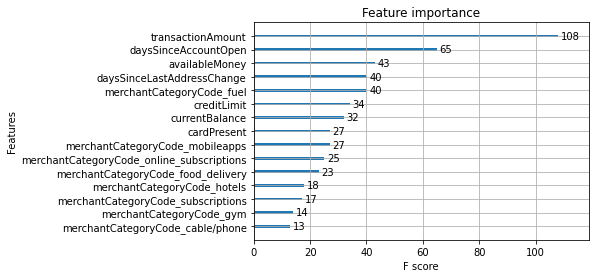

In [107]:
xgb.plot_importance(best_model,max_num_features=15)

SHAP values are awesome and can give some overview as to how each feature is impacting the model predictions.

https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30


In [109]:
explainer = shap.TreeExplainer(best_model)

In [113]:
shap_values = explainer.shap_values(X_test)

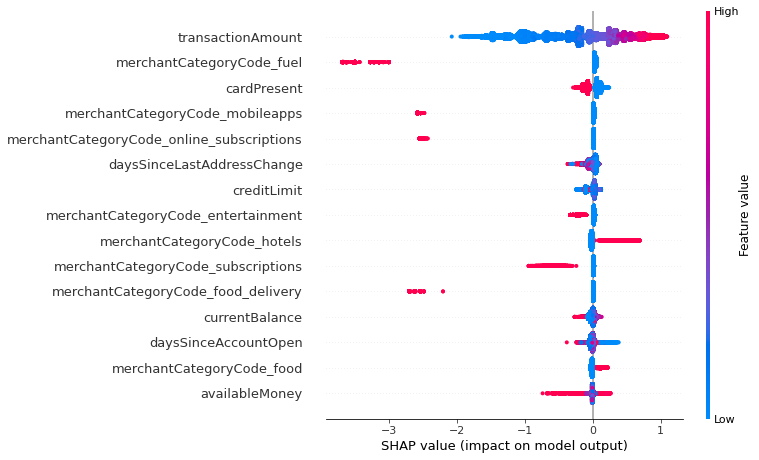

In [114]:
shap.summary_plot(shap_values, X_test, max_display=15)